In [13]:
import torch
from torch.utils.data import DataLoader, Dataset, random_split
import pandas as pd
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Load the dataset
dataset = torch.load("HAM10000Skin_Cancer_Balanced.pt")

# Extract images and metadata
images = dataset["images"]
metadata = dataset["metadata"]

# Extract labels (assume dx is stored in the first column of metadata)
labels = metadata[:, 0].long()

# Create a DataFrame for clinical data (excluding labels)
clinical_data = pd.DataFrame(metadata[:, 1:].numpy(), columns=[
    f"clinical_{i}" for i in range(1, metadata.size(1))
])

classnames = classname = [
    "Benign lesions of the keratosis",
    "Basal cell carcinoma",
    "Dermatofibroma",
    "Melanoma",
    "Melanocylabels",
    "tic nevi",
    "Vascular lesions",
    "Actinic keratoses"
]
label_dict = {abbr: name for abbr, name in zip(["bkl", "bcc", "df", "mel", "nv", "vasc", "akiec"], classnames)}

# Split data into train and test
train_ratio = 0.85
train_size = int(train_ratio * len(images))
test_size = len(images) - train_size

indices = torch.randperm(len(images)).tolist()  # Shuffle indices
train_indices, test_indices = indices[:train_size], indices[train_size:]

# Split data
X_train_images = images[train_indices]
X_test_images = images[test_indices]
X_train_clin = clinical_data.iloc[train_indices]
X_test_clin = clinical_data.iloc[test_indices]
y_train = labels[train_indices]
y_test = labels[test_indices]

# Create a custom dataset class
class SkinCancerDataset(Dataset):
    def __init__(self, images, clinical_data, labels):
        self.images = images
        self.clinical_data = clinical_data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "image": self.images[idx],
            "clinical_data": torch.tensor(self.clinical_data.iloc[idx].values, dtype=torch.float32),
            "label": self.labels[idx]
        }

# Create datasets
train_dataset = SkinCancerDataset(X_train_images, X_train_clin, y_train)
test_dataset = SkinCancerDataset(X_test_images, X_test_clin, y_test)

# Create dataloaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print summary
print(f"Train size: {len(train_dataset)}, Test size: {len(test_dataset)}")
print(f"Classnames: {classnames}")
print(f"Label dictionary: {label_dict}")


C:\Users\dasad\AppData\Local\Temp\ipykernel_11188\3088060718.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = torch.load("HAM10000Skin_Cancer_Balanced.pt")


RuntimeError: [enforce fail at alloc_cpu.cpp:114] data. DefaultCPUAllocator: not enough memory: you tried to allocate 16515072000 bytes.

In [2]:
import torch
import torch.nn as nn

class WeightedResnet(nn.Module):
    def __init__(self, in_channels, num_classes, initial_res_weights=0.001):
        super(WeightedResnet, self).__init__()

        # Initialize res_weights as a learnable parameter
        self.res_weights = nn.Parameter(torch.tensor(initial_res_weights, dtype=torch.float32))

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True)
        )
        self.res1 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True),
        )
        self.res2 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1, inplace=True),
        )
        self.res3 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(0.1),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256)
        )

        self.conv5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.res4 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.Dropout(0.1),
            nn.BatchNorm2d(512)
        )

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(0.1),
            nn.Linear(256, 512)
        )

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.res1(x) + self.res_weights * x

        x = self.conv3(x)
        x = self.res2(x) + self.res_weights * x

        x = self.conv4(x)
        x = self.res3(x) + self.res_weights * x

        x = self.conv5(x)
        x = self.res4(x) + self.res_weights * x

        x = self.classifier(x)
        x = self.softmax(x)

        return x


In [14]:
class ClinicalNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(ClinicalNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 256)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x



In [15]:
class FeaturewiseMultiplication(nn.Module):
    def __init__(self, image_model, clinical_model, num_classes, image_feature_dim=512, clinical_feature_dim=256):
        super(FeaturewiseMultiplication, self).__init__()
        self.image_model = image_model
        self.clinical_model = clinical_model

        # Project clinical features to match image features
        self.clinical_projection = nn.Linear(clinical_feature_dim, image_feature_dim)

        # Fully connected layers
        self.fc1 = nn.Linear(image_feature_dim, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()

    def forward(self, image, clinical):
        # Extract features
        image_features = self.image_model(image)  # (batch_size, image_feature_dim)
        clinical_features = self.clinical_model(clinical)  # (batch_size, clinical_feature_dim)

        # Project clinical features to match image features
        clinical_features = self.clinical_projection(clinical_features)  # (batch_size, image_feature_dim)

        # Element-wise multiplication
        combined_features = image_features * clinical_features  # (batch_size, image_feature_dim)

        # Fully connected layers
        x = self.relu(self.fc1(combined_features))
        x = self.fc2(x)
        return x

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score

# Set the device for training (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize models
num_classes = len(set(labels))
resnet_model = WeightedResnet(in_channels=3, num_classes=num_classes).to(device)
clinical_nn = ClinicalNN(input_dim=X_train_clin.shape[1], num_classes=num_classes).to(device)
combined_model = FeaturewiseMultiplication(image_model=resnet_model, clinical_model=clinical_nn, num_classes=num_classes).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(combined_model.parameters(), lr=0.001)

# DataLoader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Number of epochs
num_epochs = 100

# Lists to store metrics
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
test_recalls = []

# Training loop with tqdm and GPU support
for epoch in range(1, num_epochs + 1):
    combined_model.train()  # Set the model to training mode
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    # Train the model
    for batch in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}", ncols=100):
        images = batch["image"].to(device)
        clinical_data = batch["clinical_data"].to(device)
        labels = batch["label"].to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = combined_model(images, clinical_data)
        
        # Compute loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate loss and accuracy
        running_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)
    
    # Compute average training loss and accuracy for the epoch
    avg_train_loss = running_train_loss / len(train_loader)
    train_accuracy = correct_train / total_train * 100

    # Evaluate on test set
    combined_model.eval()  # Set the model to evaluation mode
    running_test_loss = 0.0
    correct_test = 0
    total_test = 0
    all_labels, all_predictions = [], []
    
    with torch.no_grad():  # No need to compute gradients during evaluation
        for batch in test_loader:
            images = batch["image"].to(device)
            clinical_data = batch["clinical_data"].to(device)
            labels = batch["label"].to(device)

            # Forward pass
            outputs = combined_model(images, clinical_data)
            
            # Compute loss
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()

            # Compute accuracy
            _, predicted = torch.max(outputs, 1)
            correct_test += (predicted == labels).sum().item()
            total_test += labels.size(0)

            # Collect labels and predictions for recall computation
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    # Compute average test loss and accuracy
    avg_test_loss = running_test_loss / len(test_loader)
    test_accuracy = correct_test / total_test * 100
    test_recall = recall_score(all_labels, all_predictions, average="macro") * 100

    # Store metrics for plotting
    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    test_recalls.append(test_recall)

    # Print metrics
    print(f"Epoch {epoch}/{num_epochs}")
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, Test Recall: {test_recall:.2f}%")

    # Save checkpoint periodically
    if epoch % 10 == 0:
        torch.save(combined_model.state_dict(), f"checkpoint_epoch_{epoch}.pt")

    # Early stopping condition


# Plot metrics
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 8))

# Loss curve
plt.subplot(3, 1, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

# Accuracy curve
plt.subplot(3, 1, 2)
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, test_accuracies, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Curve")
plt.legend()

# Recall curve
plt.subplot(3, 1, 3)
plt.plot(epochs, test_recalls, label="Test Recall")
plt.xlabel("Epoch")
plt.ylabel("Recall (%)")
plt.title("Recall Curve")
plt.legend()

plt.tight_layout()
plt.show()


Epoch 1/100:   5%|██▍                                              | 14/279 [00:07<02:30,  1.77it/s]


KeyboardInterrupt: 

In [6]:
torch.save(combined_model, "FeaturewiseMultiplication.pt")

Original Classnames:
0: Benign lesions of the keratosis
1: Basal cell carcinoma
2: Dermatofibroma
3: Melanoma
4: Melanocylabels
5: tic nevi
6: Vascular lesions
7: Actinic keratoses


C:\Users\dasad\AppData\Local\Temp\ipykernel_11188\1098415697.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load("FeaturewiseMultiplication.pt").t

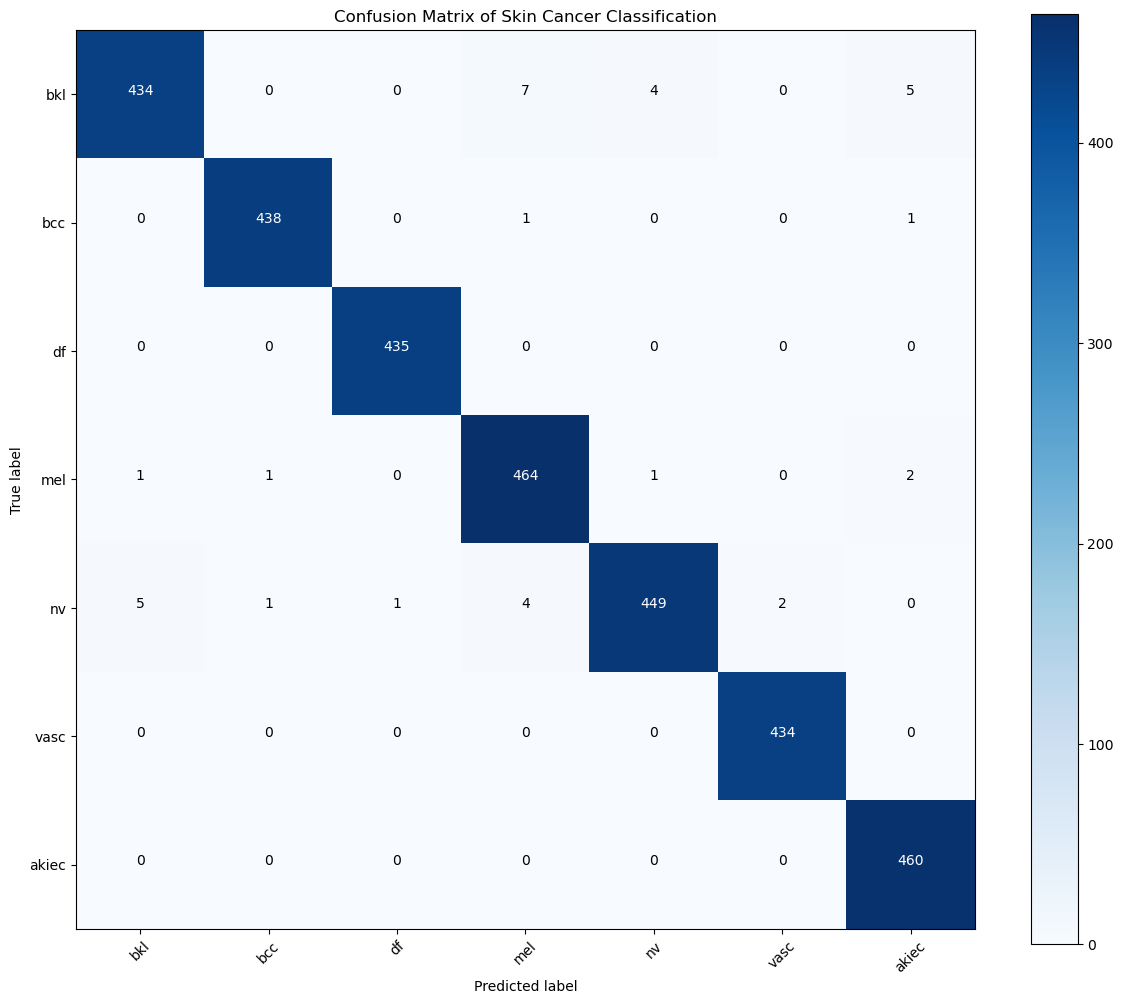

Test Data Classification Report:
               precision    recall  f1-score   support

         bkl     0.9864    0.9644    0.9753       450
         bcc     0.9955    0.9955    0.9955       440
          df     0.9977    1.0000    0.9989       435
         mel     0.9748    0.9893    0.9820       469
          nv     0.9890    0.9719    0.9803       462
        vasc     0.9954    1.0000    0.9977       434
       akiec     0.9829    1.0000    0.9914       460

    accuracy                         0.9886      3150
   macro avg     0.9888    0.9887    0.9887      3150
weighted avg     0.9886    0.9886    0.9885      3150


Training Data Classification Report:
               precision    recall  f1-score   support

         bkl     0.9824    0.9824    0.9824      2550
         bcc     0.9938    0.9969    0.9953      2560
          df     0.9992    1.0000    0.9996      2565
         mel     0.9758    0.9885    0.9821      2531
          nv     0.9894    0.9586    0.9738      2538
     

In [21]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Print out the original classnames to verify
print("Original Classnames:")
for i, name in enumerate(classnames):
    print(f"{i}: {name}")

# Corrected label dictionary to match exact class names
label_dict = {
    "bkl": "Benign lesions of the keratosis",
    "bcc": "Basal cell carcinoma", 
    "df": "Dermatofibroma", 
    "mel": "Melanoma", 
    "nv": "Melanocytic nevi", 
    "vasc": "Vascular lesions", 
    "akiec": "Actinic keratoses"
}

# Reverse the dictionary for abbreviation lookup
abbrev_dict = {v: k for k, v in label_dict.items()}

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded_model = torch.load("FeaturewiseMultiplication.pt").to(device)
loaded_model.eval()

# Prepare to collect predictions and true labels
all_preds = []
all_labels = []

# Collect predictions
with torch.no_grad():
    for batch in test_loader:
        images = batch["image"].to(device)
        clinical_data = batch["clinical_data"].to(device)
        labels = batch["label"].to(device)
        
        outputs = loaded_model(images, clinical_data)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Prepare class names and abbreviations
# Directly use the original classnames list
class_names = classnames
class_abbrevs = list(label_dict.keys())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix of Skin Cancer Classification')
plt.colorbar()

# Add text annotations
tick_marks = np.arange(len(class_abbrevs))
plt.xticks(tick_marks, class_abbrevs, rotation=45)
plt.yticks(tick_marks, class_abbrevs)

# Add text values in each cell
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Compute classification report
report = classification_report(
    all_labels, 
    all_preds, 
    target_names=class_abbrevs,
    digits=4
)
print("Test Data Classification Report:\n", report)

# Same for training data
train_preds = []
train_labels = []

with torch.no_grad():
    for batch in train_loader:
        images = batch["image"].to(device)
        clinical_data = batch["clinical_data"].to(device)
        labels = batch["label"].to(device)
        
        outputs = loaded_model(images, clinical_data)
        _, preds = torch.max(outputs, 1)
        
        train_preds.extend(preds.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
train_preds = np.array(train_preds)
train_labels = np.array(train_labels)

# Compute training classification report
train_report = classification_report(
    train_labels, 
    train_preds, 
    target_names=class_abbrevs,
    digits=4
)
print("\nTraining Data Classification Report:\n", train_report)

In [18]:
class_names = classnames 

IndexError: index 7 is out of bounds for axis 1 with size 7

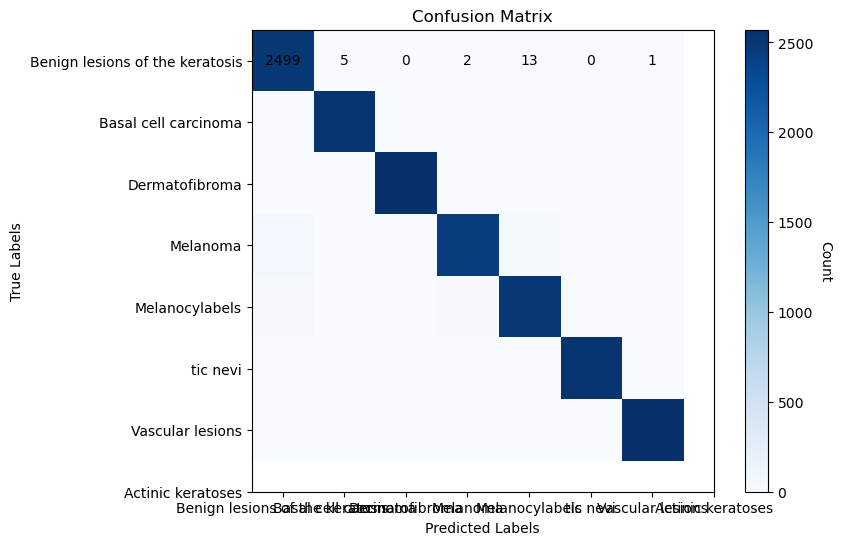

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

# Function to plot confusion matrix using Matplotlib
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(cm, cmap="Blues")

    # Add colorbar
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel("Count", rotation=-90, va="bottom")

    # Set ticks and labels
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)

    # Labeling the axes
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')

    # Loop over data dimensions and create text annotations
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            ax.text(j, i, cm[i, j], ha="center", va="center", color="black")

    plt.tight_layout()
    plt.show()

# Function to plot ROC curve
def plot_roc_curve(y_true, y_prob, class_names):
    lb = LabelBinarizer()
    y_true_bin = lb.fit_transform(y_true)
    
    plt.figure(figsize=(8, 6))
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Function to display classification report
def display_classification_report(y_true, y_pred, class_names):
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

# Train Evaluation
combined_model.eval()
train_preds = []
train_labels = []
train_probs = []
with torch.no_grad():
    for batch in train_loader:
        images = batch["image"].to(device)
        clinical_data = batch["clinical_data"].to(device)
        labels = batch["label"].to(device)

        # Forward pass
        outputs = combined_model(images, clinical_data)
        
        # Get predictions and probabilities
        _, predicted = torch.max(outputs, 1)
        train_preds.extend(predicted.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())
        train_probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())

# Plot confusion matrix and classification report for train
plot_confusion_matrix(train_labels, train_preds, class_names)
display_classification_report(train_labels, train_preds, class_names)
plot_roc_curve(train_labels, np.array(train_probs), class_names)

# Test Evaluation
combined_model.eval()
test_preds = []
test_labels = []
test_probs = []
with torch.no_grad():
    for batch in test_loader:
        images = batch["image"].to(device)
        clinical_data = batch["clinical_data"].to(device)
        labels = batch["label"].to(device)

        # Forward pass
        outputs = combined_model(images, clinical_data)
        
        # Get predictions and probabilities
        _, predicted = torch.max(outputs, 1)
        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())
        test_probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())

# Plot confusion matrix and classification report for test
plot_confusion_matrix(test_labels, test_preds, class_names)
display_classification_report(test_labels, test_preds, class_names)
plot_roc_curve(test_labels, np.array(test_probs), class_names)


In [9]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

# Load the combined model and weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize models
num_classes = len(set(labels))
resnet_model = WeightedResnet(in_channels=3, num_classes=num_classes).to(device)
clinical_nn = ClinicalNN(input_dim=X_train_clin.shape[1], num_classes=num_classes).to(device)
combined_model = FeaturewiseMultiplication(image_model=resnet_model, clinical_model=clinical_nn, num_classes=num_classes).to(device)
combined_model.load_state_dict(torch.load("FeaturewiseMultiplication.pt", map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))
combined_model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Function to plot confusion matrix using Matplotlib
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(cm, cmap="Blues")

    # Add colorbar
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel("Count", rotation=-90, va="bottom")

    # Set ticks and labels
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)

    # Labeling the axes
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')

    # Loop over data dimensions and create text annotations
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            ax.text(j, i, cm[i, j], ha="center", va="center", color="black")

    plt.tight_layout()
    plt.show()

# Function to plot ROC curve
def plot_roc_curve(y_true, y_prob, class_names):
    lb = LabelBinarizer()
    y_true_bin = lb.fit_transform(y_true)
    
    plt.figure(figsize=(8, 6))
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Function to display classification report
def display_classification_report(y_true, y_pred, class_names):
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Train Evaluation
combined_model.eval()
train_preds = []
train_labels = []
train_probs = []
with torch.no_grad():
    for batch in train_loader:
        images = batch["image"].to(device)
        clinical_data = batch["clinical_data"].to(device)
        labels = batch["label"].to(device)

        # Forward pass
        outputs = combined_model(images, clinical_data)
        
        # Get predictions and probabilities
        _, predicted = torch.max(outputs, 1)
        train_preds.extend(predicted.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())
        train_probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())

# Plot confusion matrix and classification report for train
plot_confusion_matrix(train_labels, train_preds, class_names)
display_classification_report(train_labels, train_preds, class_names)
plot_roc_curve(train_labels, np.array(train_probs), class_names)

# Test Evaluation
test_preds = []
test_labels = []
test_probs = []
with torch.no_grad():
    for batch in test_loader:
        images = batch["image"].to(device)
        clinical_data = batch["clinical_data"].to(device)
        labels = batch["label"].to(device)

        # Forward pass
        outputs = combined_model(images, clinical_data)
        
        # Get predictions and probabilities
        _, predicted = torch.max(outputs, 1)
        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())
        test_probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())

# Plot confusion matrix and classification report for test
plot_confusion_matrix(test_labels, test_preds, class_names)
display_classification_report(test_labels, test_preds, class_names)
plot_roc_curve(test_labels, np.array(test_probs), class_names)


C:\Users\dasad\AppData\Local\Temp\ipykernel_11188\1907484329.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  combined_model.load_state_dict(torch.load("FeaturewiseMulti

TypeError: Expected state_dict to be dict-like, got <class '__main__.FeaturewiseMultiplication'>.

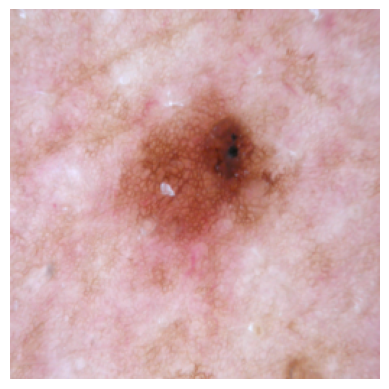

Clinical Data:
    Age Dx Type     Sex  Localization
0  70.0          Female  Abdomen, Ear

Prediction Probabilities:
Benign lesions of the keratosis: 0.1301
Basal cell carcinoma: 0.0001
Dermatofibroma: 0.0000
Melanoma: 0.4388
Melanocytic nevi: 0.4175
Vascular lesions: 0.0000
Actinic keratoses: 0.0135

Actual Class: Melanocytic nevi
Predicted Class: Melanoma


In [9]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Select a random index from the test set
random_idx = np.random.randint(0, len(test_dataset))

# Get the sample
sample = test_dataset[random_idx]

# Get the image and clinical data
image = sample['image'].unsqueeze(0).to(device)  # Add batch dimension
clinical_data = sample['clinical_data'].unsqueeze(0).to(device)  # Add batch dimension
actual_label = sample['label']

# Get the clinical data as a DataFrame (for better display)
clinical_data_dict = sample['clinical_data'].cpu().numpy()

# Determine the dx_type based on the columns 'dx_type_confocal', 'dx_type_consensus', and 'dx_type_follow_up'
dx_type = ''
if clinical_data_dict[0] == 1:
    dx_type = 'Confocal'
elif clinical_data_dict[1] == 1:
    dx_type = 'Consensus'
elif clinical_data_dict[2] == 1:
    dx_type = 'Follow-up'

# Determine the sex based on the 'sex_female' and 'sex_male' columns
sex = ''
if clinical_data_dict[4] == 1:
    sex = 'Female'
elif clinical_data_dict[5] == 1:
    sex = 'Male'
else:
    sex = 'Unknown'

# Determine the localization (only the body part where lesion is located is shown)
localization = []
local_columns = [
    'local_abdomen', 'local_acral', 'local_back', 'local_chest', 'local_ear', 'local_face', 'local_foot',
    'local_genital', 'local_hand', 'local_lower extremity', 'local_neck', 'local_scalp', 'local_trunk',
    'local_unknown', 'local_upper extremity'
]
for i, loc in enumerate(local_columns):
    if clinical_data_dict[i + 6] == 1:  # Skip the first 6 columns for dx_type and sex
        localization.append(loc.replace('local_', '').replace('_', ' ').capitalize())

# Create the DataFrame
clinical_df = pd.DataFrame([{
    'Age': clinical_data_dict[0],
    'Dx Type': dx_type,
    'Sex': sex,
    'Localization': ', '.join(localization) if localization else 'Unknown'
}], columns=['Age', 'Dx Type', 'Sex', 'Localization'])

# Get the prediction from the combined model
combined_model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    output = combined_model(image, clinical_data)

# Get the probabilities of each class
probs = torch.softmax(output, dim=1).cpu().numpy().flatten()

# Define the class names based on your dataset
class_names = [
    'Benign lesions of the keratosis', 
    'Basal cell carcinoma', 
    'Dermatofibroma', 
    'Melanoma', 
    'Melanocytic nevi', 
    'Vascular lesions', 
    'Actinic keratoses'
]

# Get the predicted class
predicted_class = np.argmax(probs)

# Plot the image
plt.imshow(sample['image'].permute(1, 2, 0))  # Change from [C, H, W] to [H, W, C]
plt.axis('off')  # Hide axes
plt.show()

# Display the clinical data
print("Clinical Data:")
print(clinical_df)

# Display the prediction probabilities for each class
print("\nPrediction Probabilities:")
for idx, class_name in enumerate(class_names):
    print(f"{class_name}: {probs[idx]:.4f}")

# Display the actual class and predicted class
print("\nActual Class:", class_names[actual_label])
print("Predicted Class:", class_names[predicted_class])


In [10]:
clinical_df

Age Dx Type     Sex  Localization
0  70.0          Female  Abdomen, Ear

In [11]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import torch.nn.functional as F
import seaborn as sns
import pandas as pd

class ModelVisualizer:
    def __init__(self, model_path, device='cuda'):
        self.device = device
        self.model = torch.load(model_path).to(device)
        self.model.eval()
        
        # Define clinical feature names
        self.clinical_feature_names = [
            "Age",
            "Dx Type: Confocal",
            "Dx Type: Consensus",
            "Dx Type: Follow-Up",
            "Dx Type: Histopathology",
            "Sex: Female",
            "Sex: Male",
            "Sex: Unknown",
            "Localization: Abdomen",
            "Localization: Acral",
            "Localization: Back",
            "Localization: Chest",
            "Localization: Ear",
            "Localization: Face",
            "Localization: Foot",
            "Localization: Genital",
            "Localization: Hand",
            "Localization: Lower Extremity",
            "Localization: Neck",
            "Localization: Scalp",
            "Localization: Trunk",
            "Localization: Unknown",
            "Localization: Upper Extremity"
        ]
        
    def generate_gradcam(self, image, clinical_data, target_layer_name='conv5'):
        """
        Generate smooth Grad-CAM visualization for the image pathway
        """
        # Register hooks for the target layer
        activation = None
        gradients = None
        
        def save_activation(module, input, output):
            nonlocal activation
            activation = output
            
        def save_gradient(module, grad_input, grad_output):
            nonlocal gradients
            gradients = grad_output[0]
        
        # Find target layer
        target_layer = None
        for name, module in self.model.image_model.named_modules():
            if name == target_layer_name:
                target_layer = module
                break
                
        if target_layer is None:
            raise ValueError(f"Layer {target_layer_name} not found")
            
        # Register hooks
        handle1 = target_layer.register_forward_hook(save_activation)
        handle2 = target_layer.register_backward_hook(save_gradient)
        
        # Forward pass
        image_tensor = image.unsqueeze(0).to(self.device)
        clinical_tensor = torch.tensor(clinical_data, dtype=torch.float32).unsqueeze(0).to(self.device)
        
        output = self.model(image_tensor, clinical_tensor)
        pred = output.argmax(dim=1)
        
        # Backward pass
        self.model.zero_grad()
        output[0, pred].backward()
        
        # Remove hooks
        handle1.remove()
        handle2.remove()
        
        # Generate CAM
        weights = gradients.mean(dim=(2, 3))
        cam = (weights.unsqueeze(-1).unsqueeze(-1) * activation).sum(dim=1)
        cam = F.relu(cam)
        
        # Normalize and resize
        cam = F.interpolate(cam.unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False)
        cam = cam.squeeze().cpu().detach().numpy()
        
        # Apply Gaussian blur for smoothness
        cam = cv2.GaussianBlur(cam, (15, 15), 10)
        
        # Normalize to [0, 1]
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        
        return cam
    
    def generate_clinical_importance(self, clinical_data):
        """
        Generate feature importance visualization for clinical pathway
        """
        # Get weights from the first layer of clinical model
        weights = self.model.clinical_model.fc1.weight.detach().cpu().numpy()
        
        # Calculate feature importance as L1 norm of weights
        importance = np.abs(weights).mean(axis=0)
        
        # Normalize importance scores
        importance = (importance - importance.min()) / (importance.max() - importance.min() + 1e-8)
        
        return importance
    
    def visualize(self, image, clinical_data, class_names):
        """
        Generate comprehensive visualization
        """
        # Generate attributions
        cam = self.generate_gradcam(image, clinical_data)
        clinical_importance = self.generate_clinical_importance(clinical_data)
        
        # Create visualization
        fig = plt.figure(figsize=(20, 12))
        
        # Plot original image
        ax1 = plt.subplot(2, 2, 1)
        plt.imshow(image.permute(1, 2, 0).cpu())
        plt.title('Original Image', fontsize=12, pad=10)
        plt.axis('off')
        
        # Plot Grad-CAM
        ax2 = plt.subplot(2, 2, 2)
        plt.imshow(image.permute(1, 2, 0).cpu())
        plt.imshow(cam, cmap='jet', alpha=0.5)
        plt.title('Grad-CAM Visualization', fontsize=12, pad=10)
        plt.axis('off')
        
        # Plot clinical feature importance
        ax3 = plt.subplot(2, 1, 2)
        importance_df = pd.DataFrame({
            'Feature': self.clinical_feature_names,
            'Importance': clinical_importance
        })
        importance_df = importance_df.sort_values('Importance', ascending=True)
        
        sns.barplot(data=importance_df, y='Feature', x='Importance', 
                   palette='viridis', ax=ax3)
        plt.title('Clinical Feature Importance', fontsize=12, pad=10)
        
        # Adjust layout for better readability
        ax3.set_xlabel('Relative Importance', fontsize=10)
        ax3.set_ylabel('Clinical Features', fontsize=10)
        ax3.tick_params(axis='both', which='major', labelsize=8)
        
        plt.tight_layout()
        return fig
    
    def get_prediction(self, image, clinical_data):
        """
        Get model prediction and confidence
        """
        with torch.no_grad():
            image_tensor = image.unsqueeze(0).to(self.device)
            clinical_tensor = torch.tensor(clinical_data, 
                                        dtype=torch.float32).unsqueeze(0).to(self.device)
            
            output = self.model(image_tensor, clinical_tensor)
            probabilities = F.softmax(output, dim=1)
            
            pred_class = torch.argmax(probabilities).item()
            confidence = probabilities[0][pred_class].item()
            
        return pred_class, confidence

def plot_sample_predictions(visualizer, test_loader, class_names, num_samples=5):
    """
    Plot sample predictions with visualizations
    """
    samples = []
    for batch in test_loader:
        if len(samples) >= num_samples:
            break
        samples.extend([(batch['image'][i], 
                        batch['clinical_data'][i], 
                        batch['label'][i]) 
                       for i in range(len(batch['label']))])
    
    samples = samples[:num_samples]
    
    for image, clinical_data, true_label in samples:
        pred_class, confidence = visualizer.get_prediction(image, clinical_data)
        
        fig = visualizer.visualize(image, clinical_data, class_names)
        
        plt.suptitle(f'True: {class_names[true_label]}\n' \
                    f'Predicted: {class_names[pred_class]} ' \
                    f'(Confidence: {confidence:.2f})', 
                    y=1.02, fontsize=14)
        plt.show()

C:\Users\dasad\AppData\Local\Temp\ipykernel_12164\301255111.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model = torch.load(model_path).to(device)
C:\Users\dasa

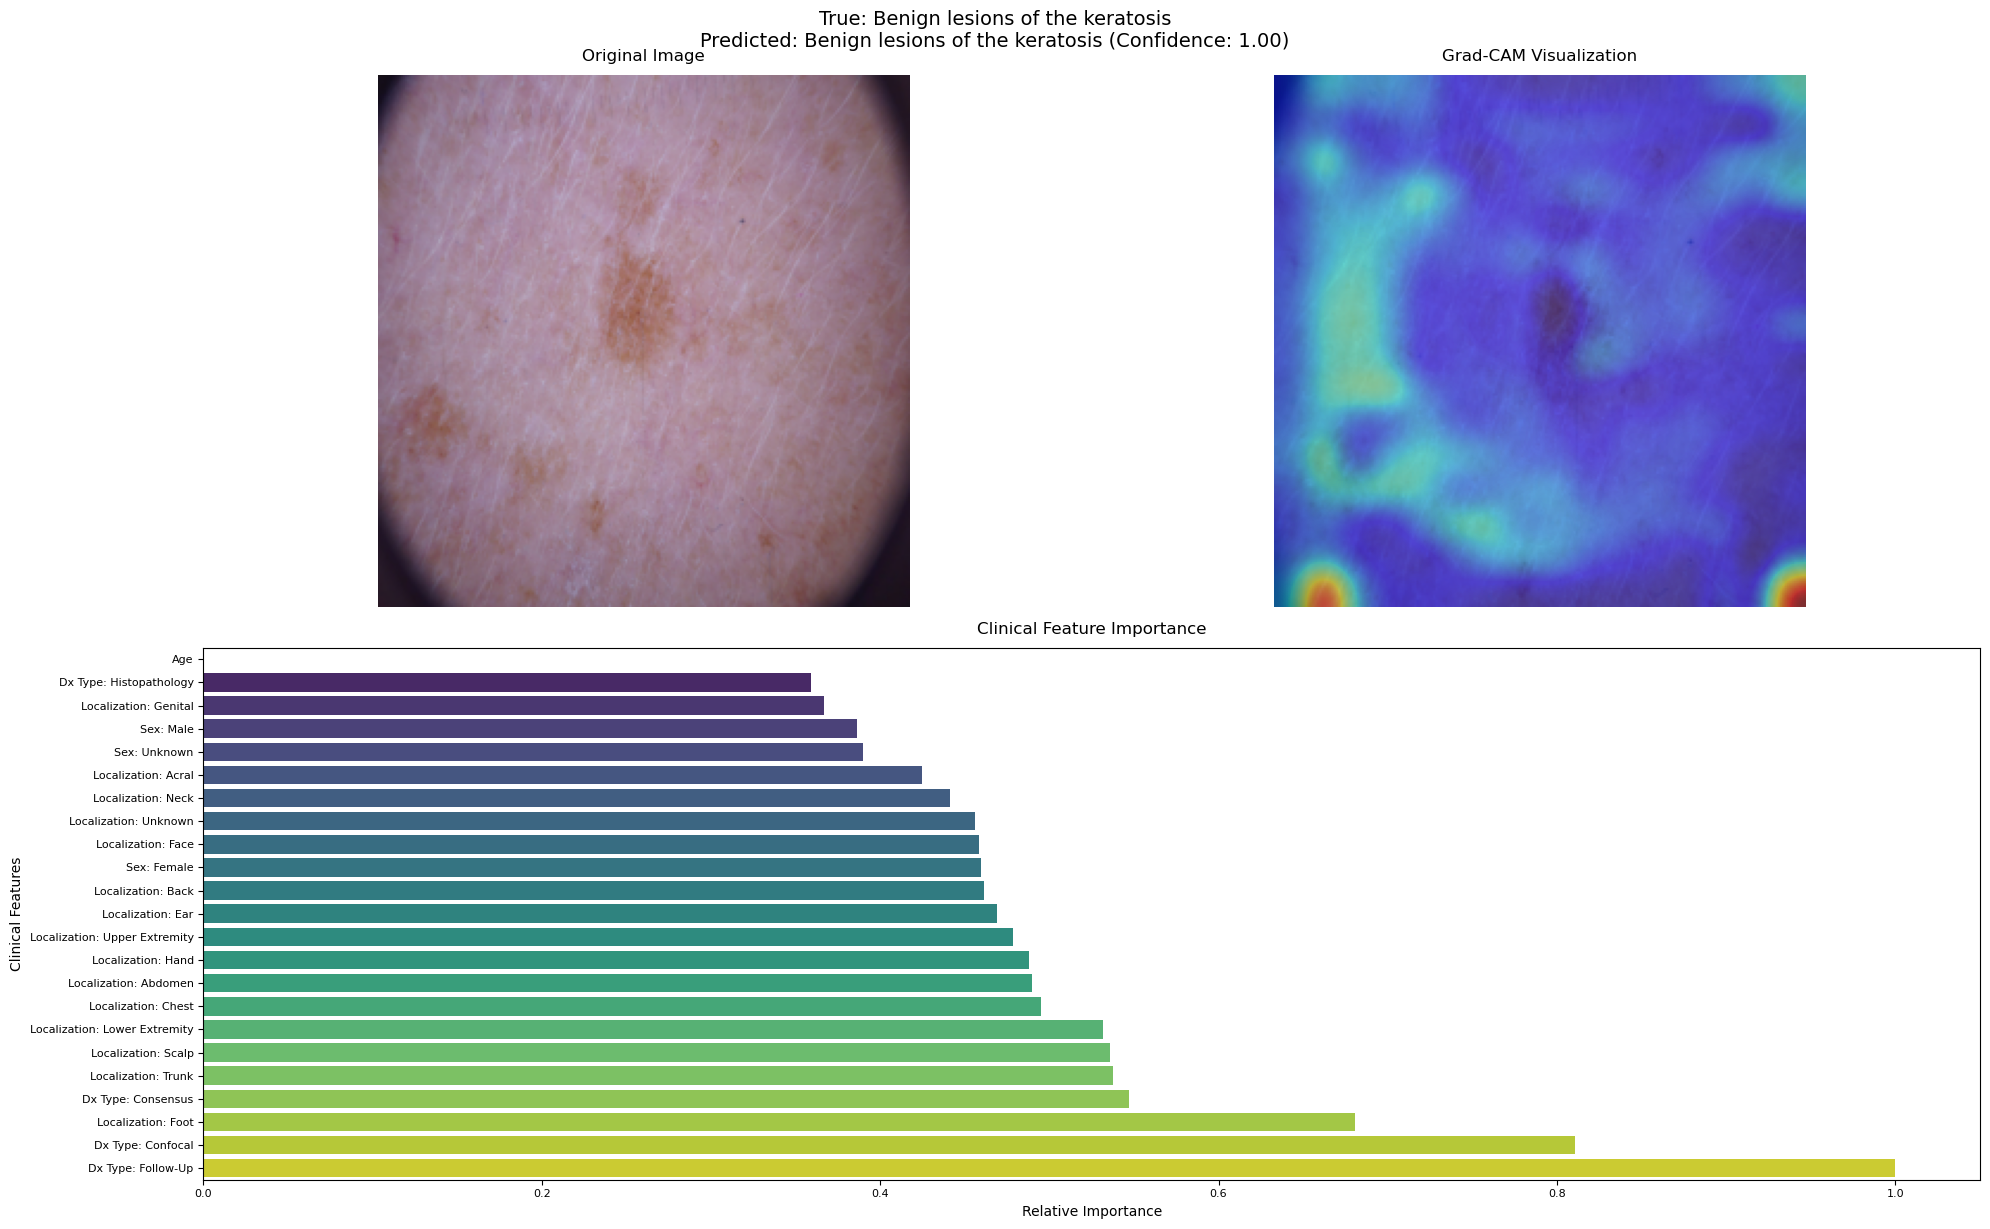

C:\Users\dasad\AppData\Local\Temp\ipykernel_12164\301255111.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  clinical_tensor = torch.tensor(clinical_data,
C:\Users\dasad\AppData\Local\Temp\ipykernel_12164\301255111.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  clinical_tensor = torch.tensor(clinical_data, dtype=torch.float32).unsqueeze(0).to(self.device)
C:\Users\dasad\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook 

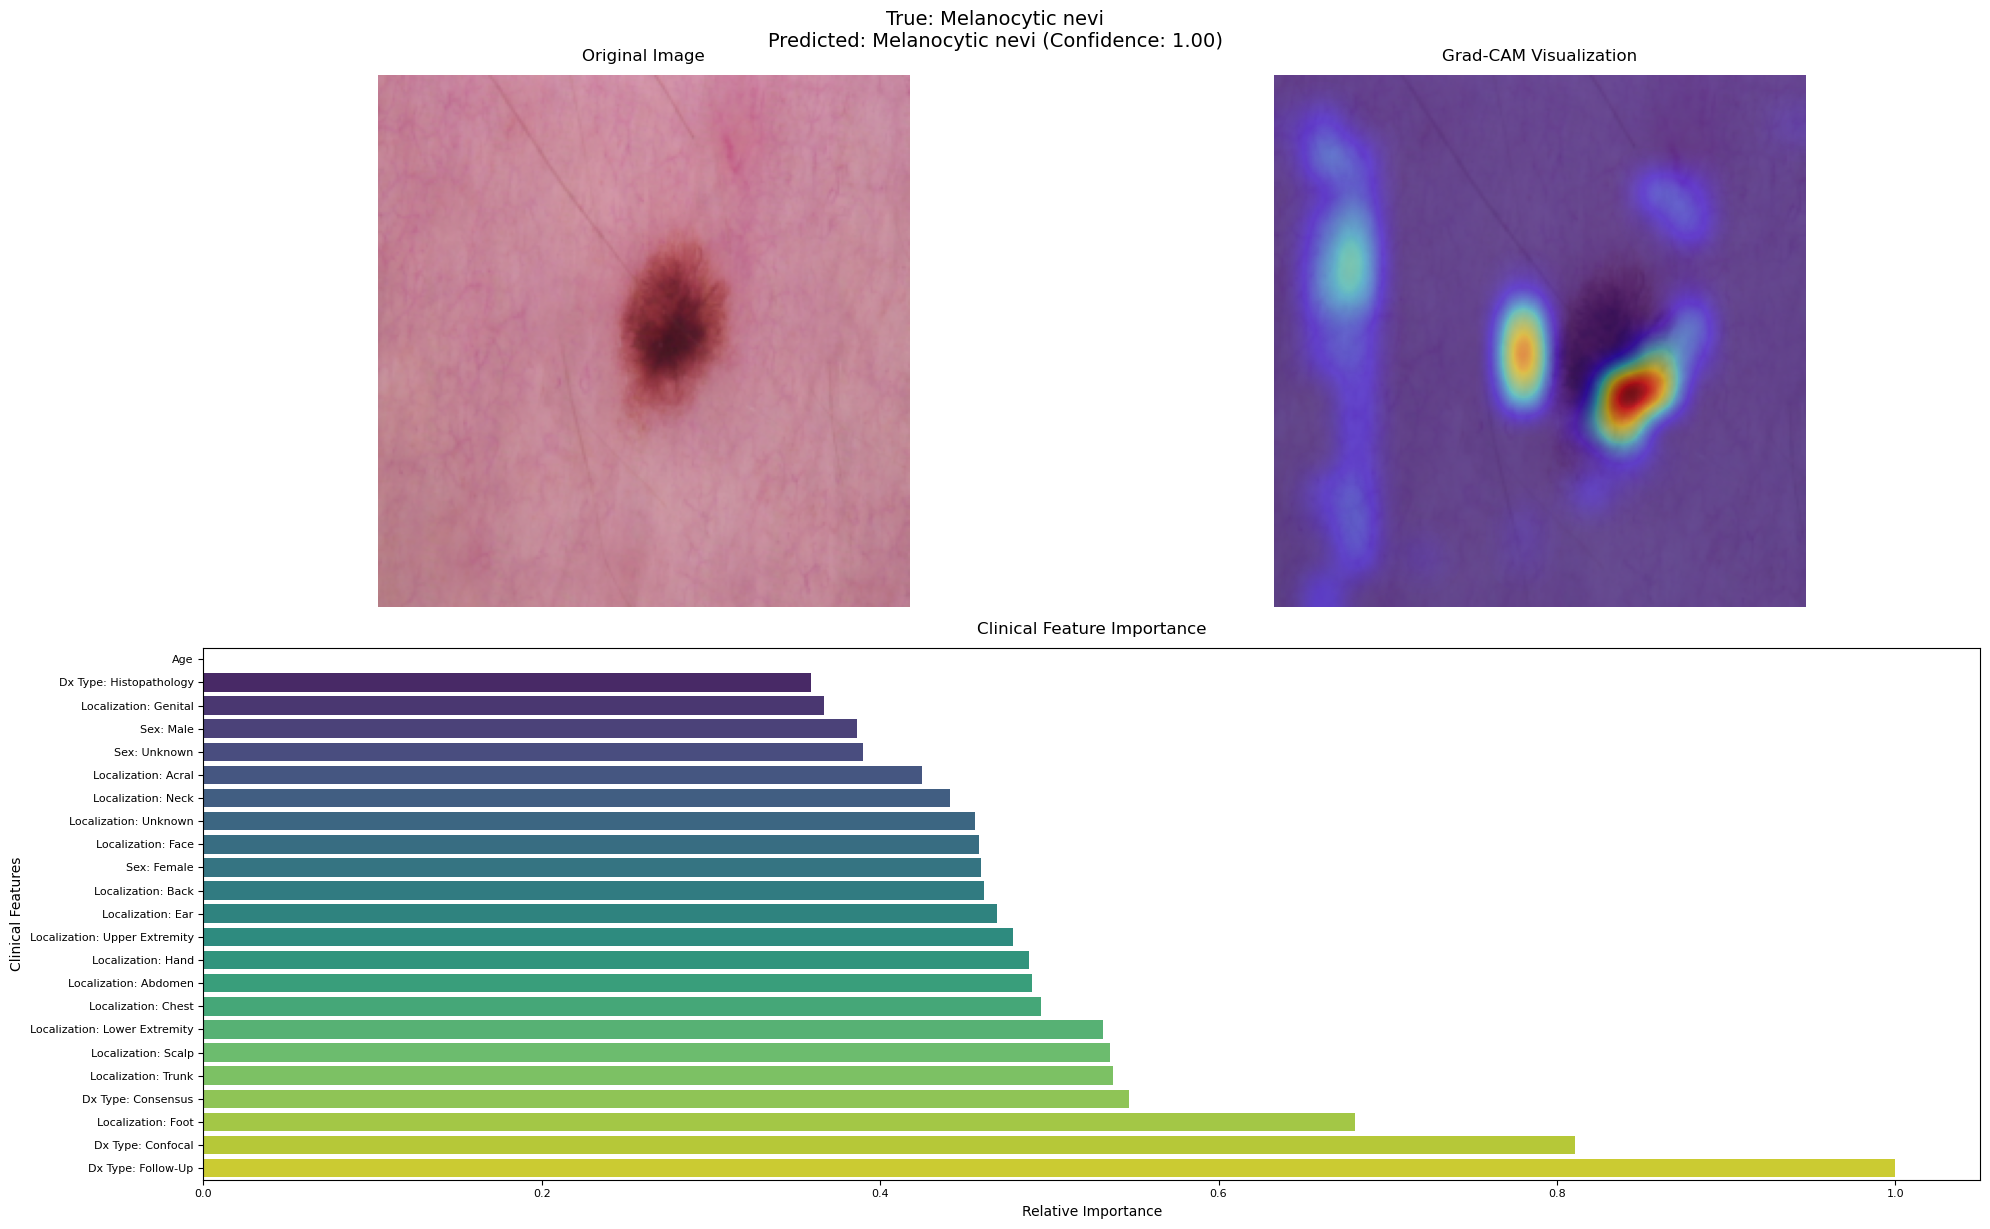

C:\Users\dasad\AppData\Local\Temp\ipykernel_12164\301255111.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  clinical_tensor = torch.tensor(clinical_data,
C:\Users\dasad\AppData\Local\Temp\ipykernel_12164\301255111.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  clinical_tensor = torch.tensor(clinical_data, dtype=torch.float32).unsqueeze(0).to(self.device)
C:\Users\dasad\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook 

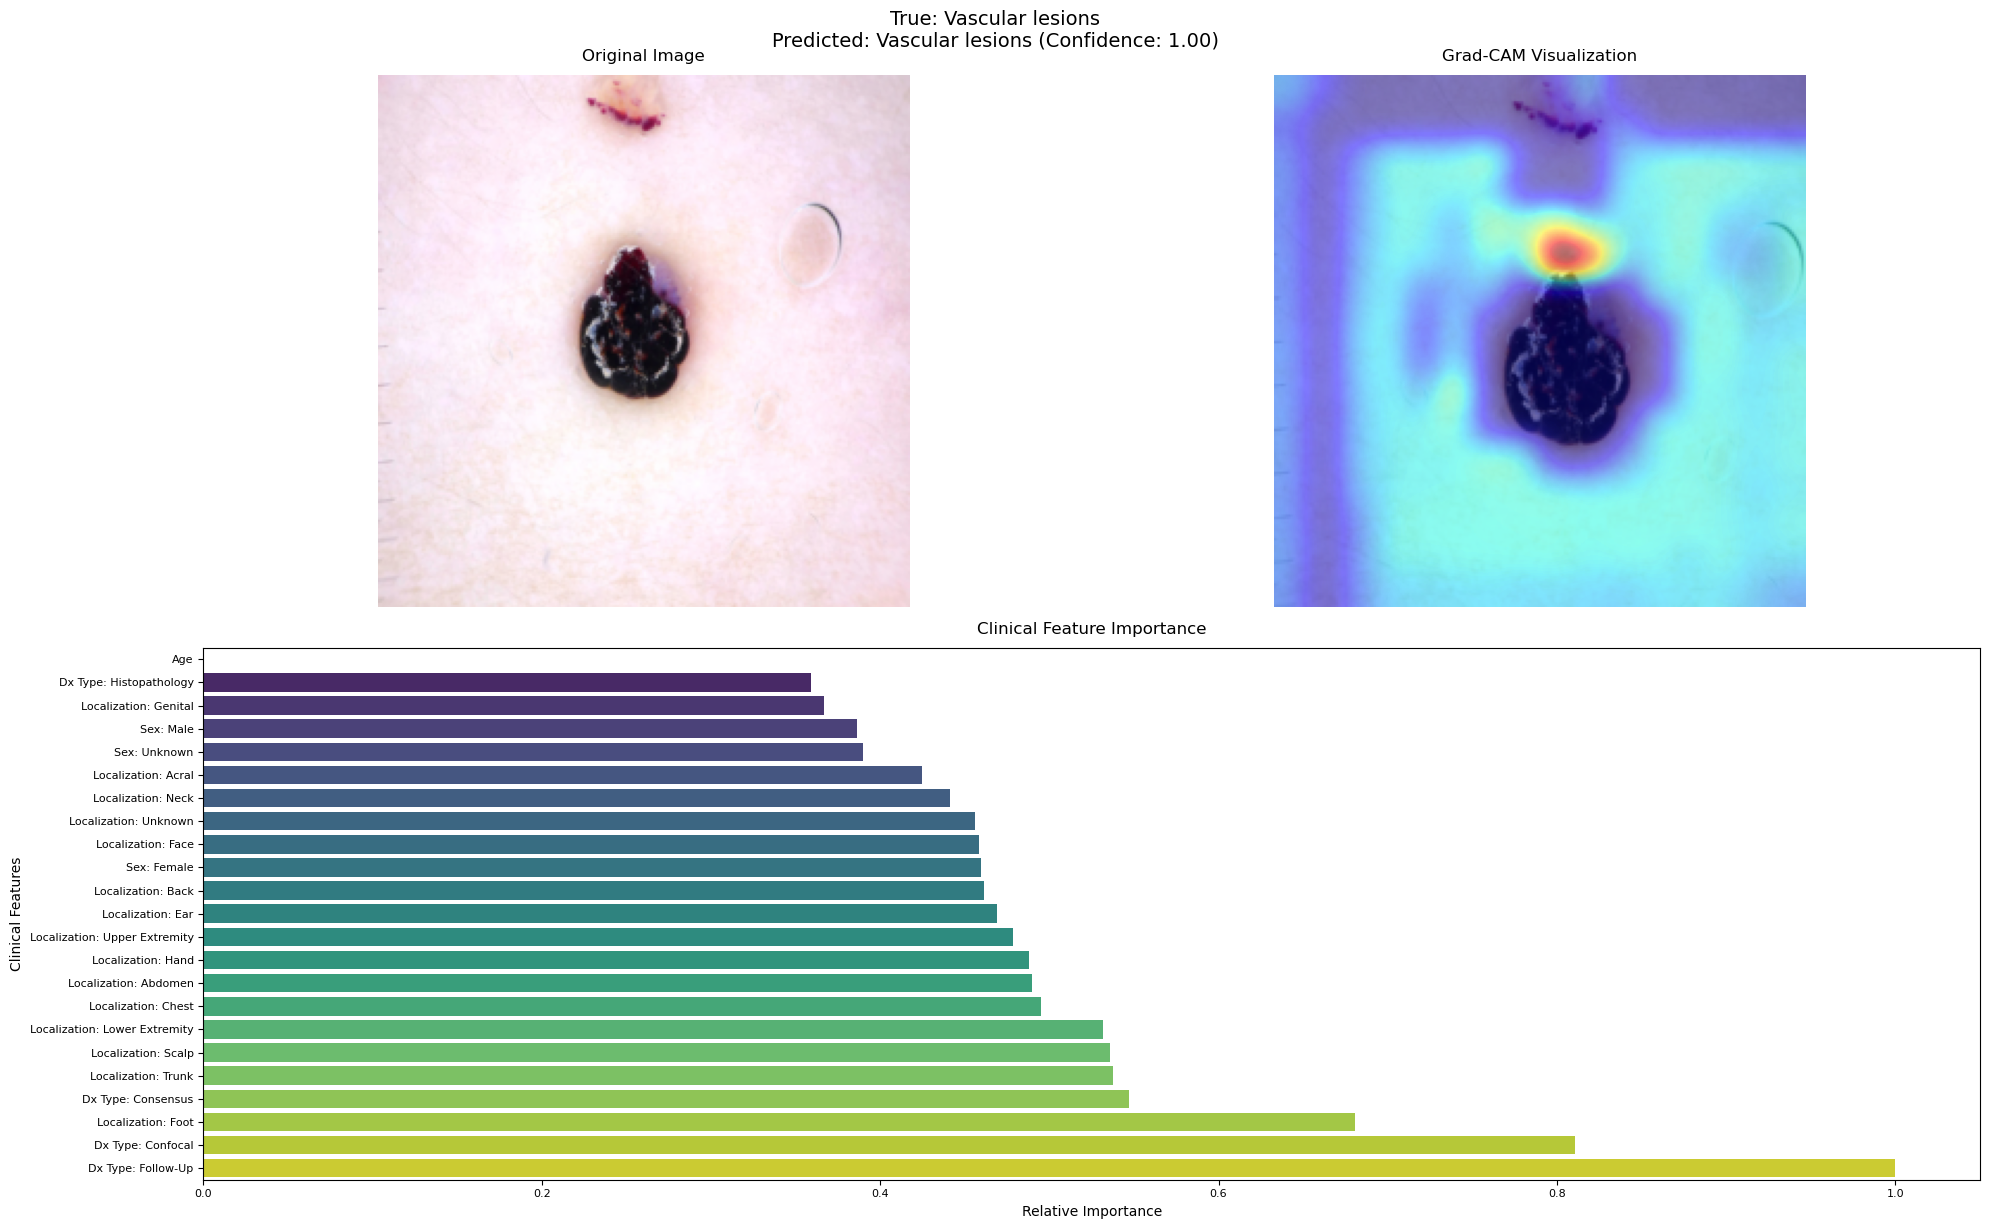

C:\Users\dasad\AppData\Local\Temp\ipykernel_12164\301255111.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  clinical_tensor = torch.tensor(clinical_data,
C:\Users\dasad\AppData\Local\Temp\ipykernel_12164\301255111.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  clinical_tensor = torch.tensor(clinical_data, dtype=torch.float32).unsqueeze(0).to(self.device)
C:\Users\dasad\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook 

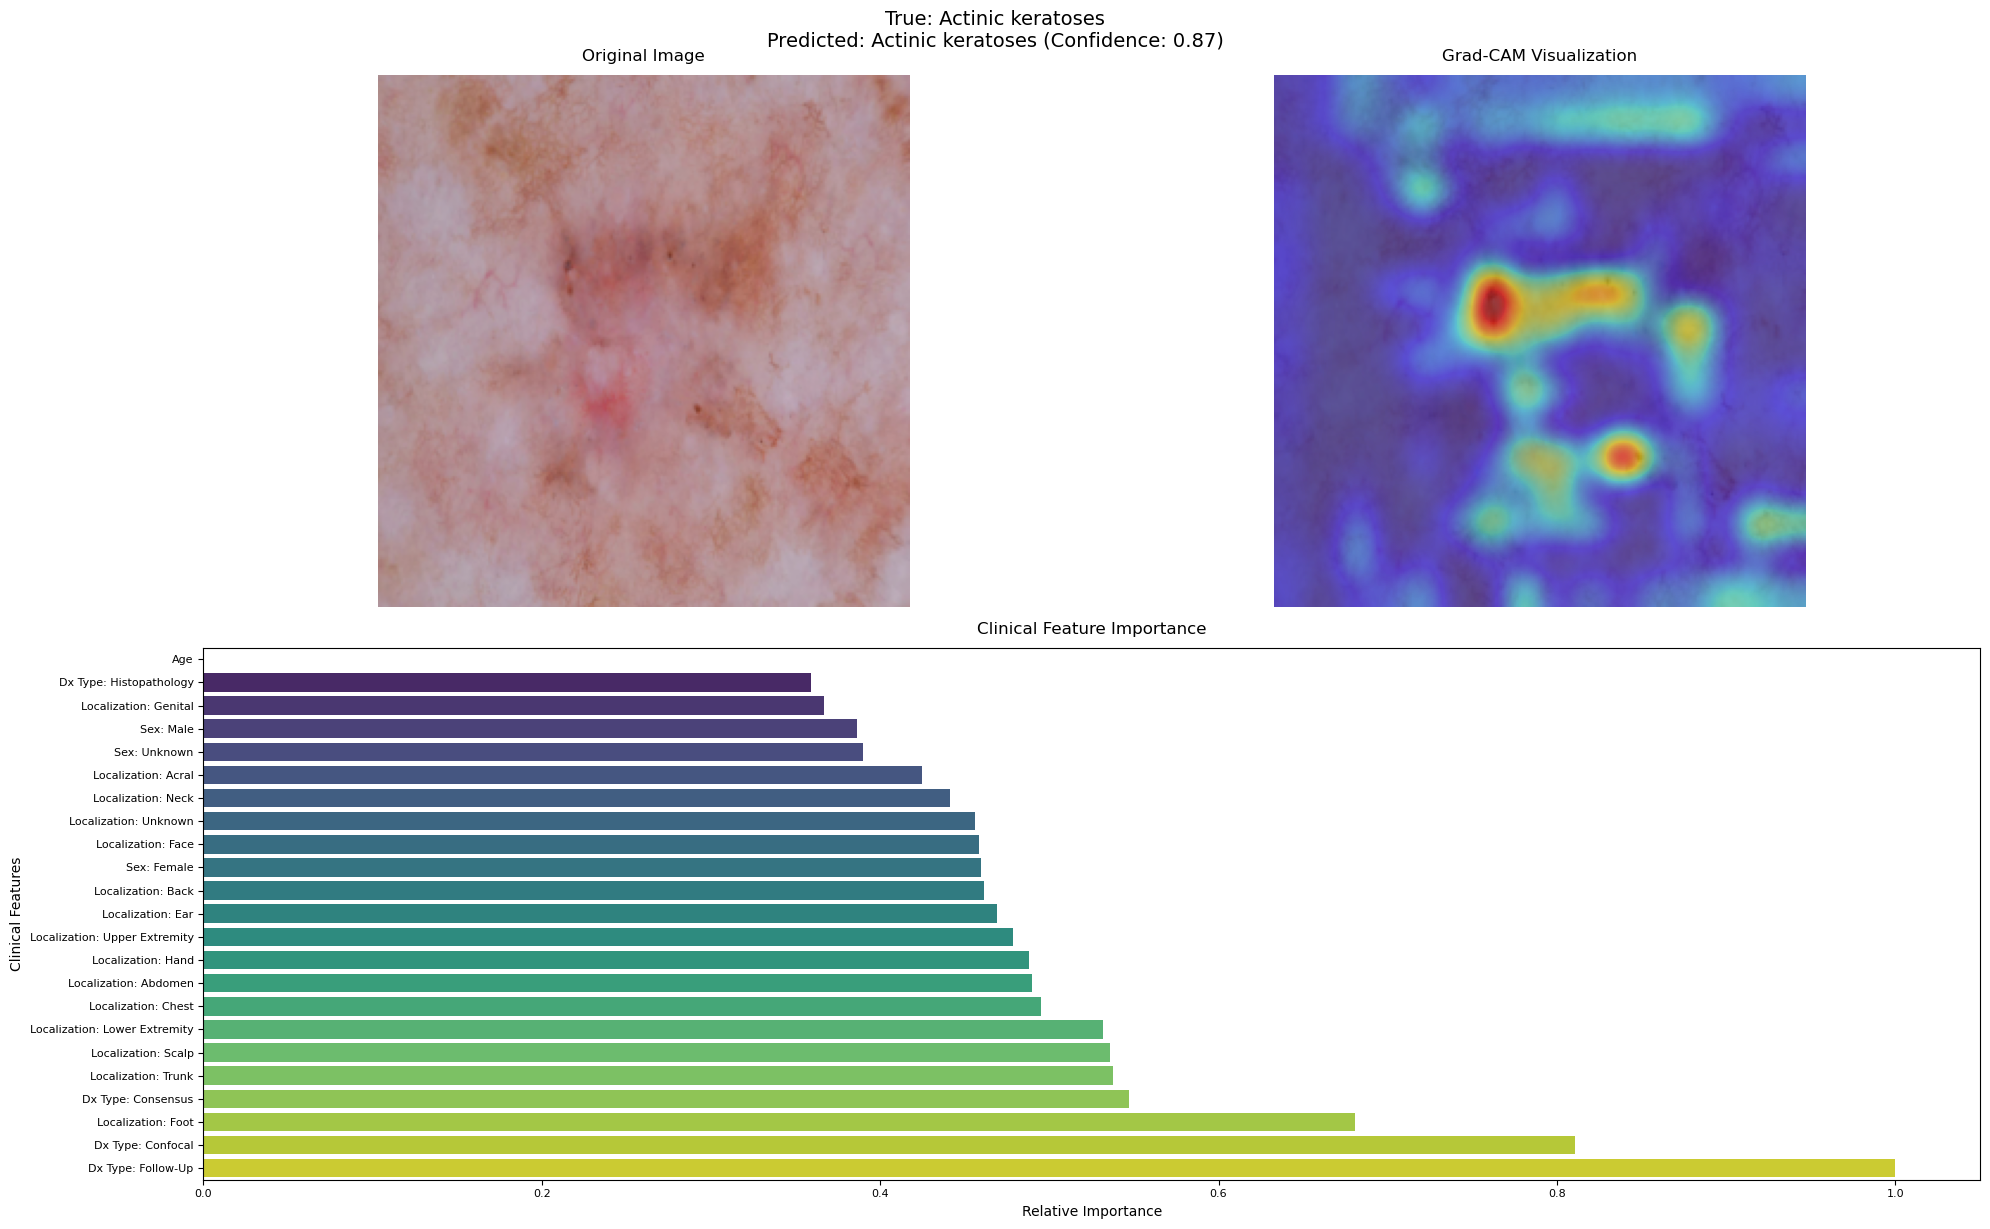

C:\Users\dasad\AppData\Local\Temp\ipykernel_12164\301255111.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  clinical_tensor = torch.tensor(clinical_data,
C:\Users\dasad\AppData\Local\Temp\ipykernel_12164\301255111.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  clinical_tensor = torch.tensor(clinical_data, dtype=torch.float32).unsqueeze(0).to(self.device)
C:\Users\dasad\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook 

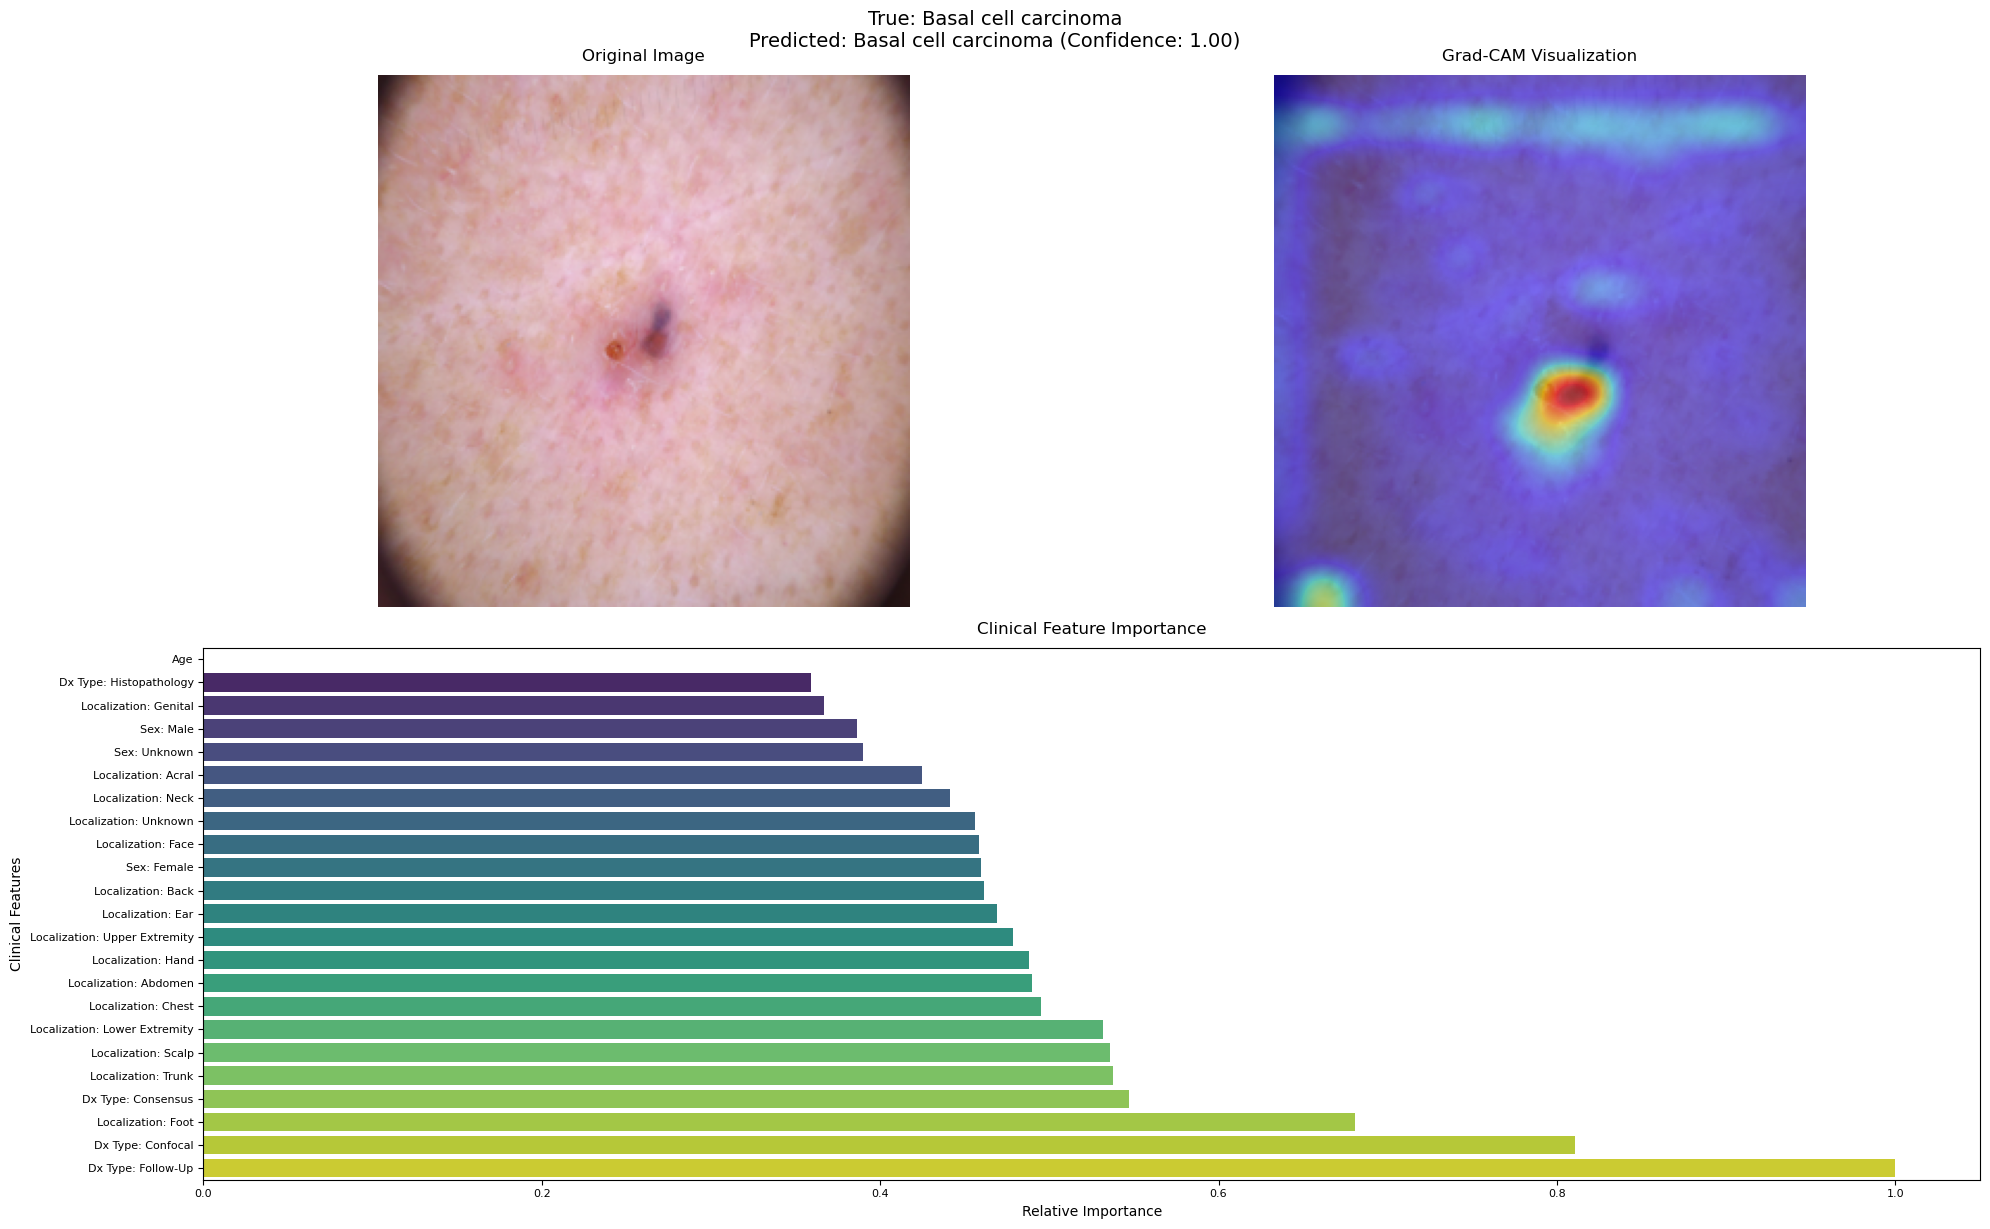

In [16]:
# Initialize the visualizer
visualizer = ModelVisualizer("FeaturewiseMultiplication.pt")

# Generate visualizations for sample predictions
plot_sample_predictions(visualizer, test_loader, classnames)